# Getting Started with DoWhy

[DoWhy](https://github.com/Microsoft/dowhy) is a Python package coming out of Microsoft Research for Causal Inference. Here we're running through the documented examples [availabe in their documentation.](https://causalinference.gitlab.io/dowhy/do_why_simple_example.html)

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets

In [2]:
data = dowhy.datasets.linear_dataset(
    beta=10, # The true causal effect. This is what we want to estimate. 
    num_common_causes=5,
    num_instruments=2,
    num_samples=100,
    treatment_is_binary=True)

In [3]:
# data is just a dictionary, which gives us an idea of what DoWhy is expecting from a dataset you provide. 
print(data.keys())
# 'df' is clearly the dataframe with out data
df = data["df"]
print(df.head())

dict_keys(['df', 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names', 'dot_graph', 'gml_graph', 'ate'])
    Z0        Z1        X0        X1        X2        X3        X4    v  \
0  1.0  0.467628  2.083413 -0.666746 -0.976042  1.605411  1.076316  1.0   
1  1.0  0.634249 -0.457832 -1.825639 -1.170914 -0.648406 -0.117977  0.0   
2  1.0  0.387714  0.268992 -0.481571 -0.243331 -1.923469  0.551148  0.0   
3  1.0  0.380526  2.244750 -0.081771 -0.614900 -1.327482  0.425874  0.0   
4  1.0  0.882433  1.319917  1.198654  0.426331  0.021311  1.209215  1.0   

           y  
0  25.151337  
1 -12.004493  
2  -7.573978  
3   4.778904  
4  22.632029  


In [6]:
# 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names' are all lists of column names
print(f"Common Causes: {data['common_causes_names']}", "\n",
      f"Instrument Names: {data['instrument_names']}", "\n",
      f"Treatment Name: {data['treatment_name']}", "\n",
      f"Outcome Name: {data['outcome_name']}")

Common Causes: ['X0', 'X1', 'X2', 'X3', 'X4'] 
 Instrument Names: ['Z0', 'Z1'] 
 Treatment Name: v 
 Outcome Name: y


In [7]:
# DoWhy lets you provide in the causal graph in two formats.  Either in the GML format
# or the DOT format.  They recommend that you use the GML format, though it's longer
# and seems worse.
print(data['dot_graph'], "\n",
      data['gml_graph'])

digraph { v ->y; U[label="Unobserved Confounders"]; U->v; U->y;X0-> v; X1-> v; X2-> v; X3-> v; X4-> v;X0-> y; X1-> y; X2-> y; X3-> y; X4-> y;Z0-> v; Z1-> v;} 
 graph[directed 1node[ id "v" label "v"]node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "v" target "y"]edge[source "Unobserved Confounders" target "v"]edge[source "Unobserved Confounders" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "v"] node[ id "X1" label "X1"] edge[ source "X1" target "v"] node[ id "X2" label "X2"] edge[ source "X2" target "v"] node[ id "X3" label "X3"] edge[ source "X3" target "v"] node[ id "X4" label "X4"] edge[ source "X4" target "v"]edge[ source "X0" target "y"] edge[ source "X1" target "y"] edge[ source "X2" target "y"] edge[ source "X3" target "y"] edge[ source "X4" target "y"]node[ id "Z0" label "Z0"] edge[ source "Z0" target "v"] node[ id "Z1" label "Z1"] edge[ source "Z1" target "v"]]


# Model Specification & Estimation

In this first example we provide the Causal Graph as a GML. 

In [8]:
model = CausalModel(
    data=df,
    treatment=data['treatment_name'],
    outcome = data['outcome_name'],
    graph=data['gml_graph'])

model.view_model()

['X4', 'Z0', 'X0', 'X3', 'X2', 'Unobserved Confounders', 'X1', 'Z1']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
no
{'observed': 'no'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y
Using Matplotlib for plotting


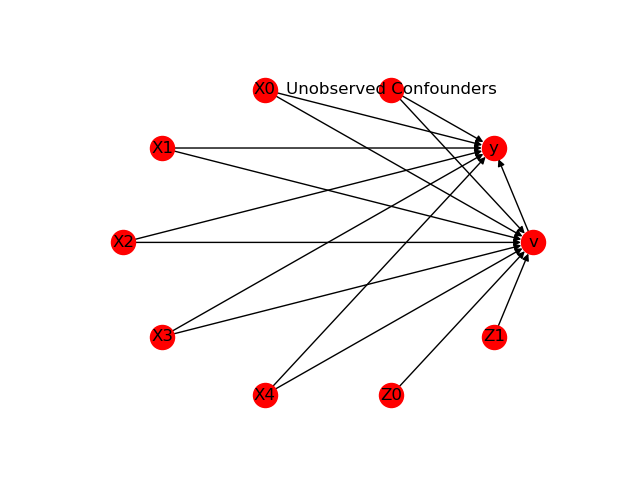

In [9]:
from IPython.display import display, Image
display(Image(filename="causal_model.png"))

In [10]:

identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X4', 'Z0', 'X0', 'X3', 'X2', 'Unobserved Confounders', 'X1', 'Z1'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  


Please respond with 'y' or 'n'


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,Z0,X0,X3,X2,X1,Z1))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,Z0,X0,X3,X2,X1,Z1,U) = P(y|v,X4,Z0,X0,X3,X2,X1,Z1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)



In [11]:
causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")
print(causal_estimate)
print(f"Causal Estimate is {causal_estimate.value}")

LinearRegressionEstimator


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+Z0+X0+X3+X2+X1+Z1


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,Z0,X0,X3,X2,X1,Z1))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,Z0,X0,X3,X2,X1,Z1,U) = P(y|v,X4,Z0,X0,X3,X2,X1,Z1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v+X4+Z0+X0+X3+X2+X1+Z1
## Estimate
Value: 9.999999999999993

Causal Estimate is 9.999999999999993


## Specify common causes instead
You don't necessarily have to specify a graph.  DoWhy will create one for you if you specify common causes in the data.

In [12]:
model= CausalModel(
        data=df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        common_causes=data["common_causes_names"],
        instruments=data['instrument_names'])

['X4', 'Z0', 'X0', 'X3', 'X2', 'X1', 'Z1']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y


Using Matplotlib for plotting


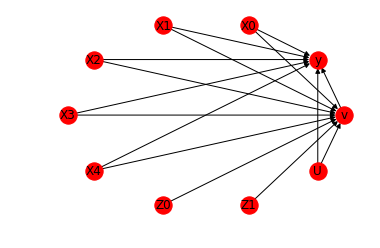

In [13]:
model.view_model()

In [19]:
identified_estimand = model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X4', 'Z0', 'X0', 'U', 'X3', 'X2', 'X1', 'Z1'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


In [25]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True
        )
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+Z0+X0+X3+X2+X1+Z1


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,Z0,X0,X3,X2,X1,Z1))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,Z0,X0,X3,X2,X1,Z1,U) = P(y|v,X4,Z0,X0,X3,X2,X1,Z1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v+X4+Z0+X0+X3+X2+X1+Z1
## Estimate
Value: 9.999999999999993

## Statistical Significance
p-value: <0.001

Causal Estimate is 9.999999999999993


# Refutations
An important part of this process is generating evidence that your causal model is accurate or not. We can do this with DoWhy is several ways.

In [16]:
# Checking our models sensitivity to adding a new random common cause
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+Z0+X0+X3+X2+X1+Z1+w_random


Refute: Add a Random Common Cause
Estimated effect:(9.999999999999993,)
New effect:(10.00000000000001,)



In [17]:
# replacing the treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~placebo+X4+Z0+X0+X3+X2+X1+Z1


Refute: Use a Placebo Treatment
Estimated effect:(9.999999999999993,)
New effect:(0.02023790636933735,)



In [18]:
# removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+Z0+X0+X3+X2+X1+Z1


Refute: Use a subset of data
Estimated effect:(9.999999999999993,)
New effect:(10.000000000000012,)



In [56]:
import matplotlib.pyplot as plt
from datetime import datetime

SMALL_SIZE = 8
MEDIUM_SIZE = 26
BIGGER_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot_treatment_outcome(treatment, outcome, time_var):
    fig, ax = plt.subplots()
    ax.plot(time_var, treatment, 'o')
    ax.plot(time_var, outcome, 'r^')

    plt.legend(loc="upper left", bbox_to_anchor=(0.4, 1))
    plt.xlabel("Time")
    fig.set_size_inches(8, 6)
    fig.savefig("poster_obs_data" + datetime.now().strftime("%H-%M-%s") + ".png",
                bbox_inches="tight")


def plot_causal_effect(estimate, treatment, outcome):
    fig, ax = plt.subplots(figsize = (10, 10))
    x_min = 0
    x_max = max(treatment)
    y_min = estimate.params["intercept"]
    y_max = y_min + estimate.value * (x_max - x_min)
    ax.scatter(treatment, outcome, c="gray", marker="o", label="Observed data")
    ax.plot([x_min, x_max], [y_min, y_max], c="black", ls="solid", lw=4,
            label="Causal variation")
    ax.set_ylim(0, max(outcome))
    ax.set_xlim(0, x_max)

    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    ax.text(0.8, 1, r"DoWhy estimate $\rho$ (slope) = " + str(round(estimate.value, 2)),
            ha="right", va="bottom", size=20, bbox=bbox_props)
    ax.legend(loc="upper left")
    plt.xlabel("Treatment")
    plt.ylabel("Outcome")

    fig.set_size_inches(8, 6)

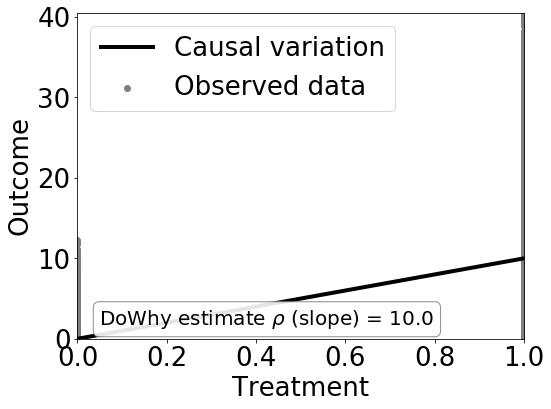

In [57]:
plot_causal_effect(estimate, 
                   treatment=df[data['treatment_name']],
                   outcome=df[data["outcome_name"]])

# Some Examples from Causality

Ultimately, we want to be able to have a package in Python that we can use to generally evaluate a Causal Graph.  DoWhy seems like it will get us close, but not quite there.  I haven't been able to find an example of front-door adjustment, though it does seem to do back-door adjustment and instrumental variables.  But how does it handle unobserved variables? Bayesian models and uncertainty estimates? I would like to begin to identify the features in DoWhy that I like, and where I think it will need to be extended.  We'll use examples from the Book of Why and Causality to explore the edges. 

Features that work really well:

* asdf

Features that I will need to add or change:

* asdf

## Example 1: Slippery Sidewalks

This is a classic problem that we'll do some exploratory work with. 

In [4]:
# GML graph specification
# For some reason this one is recommended.... But it's sooo much longer.
graph_gml = """graph[directed 1 node[id "Z" label "Z"]
                    node[id "A" label "A"]
                    node[id "B" label "B"]
                    node[id "X" label "X"]
                    node[id "Y" label "Y"]
                    edge[source "Z" target "A"]
                    edge[source "Z" target "B"]
                    edge[source "A" target "X"]
                    edge[source "B" target "X"]
                    edge[source "X" target "Y"]]"""

# Equivalent DOT graph
graph_dot = "digraph {Z -> A;Z -> B;A -> X;B -> X;X -> Y;}"

In [7]:
# Generate some fake data
nrows = 100
data = pd.DataFrame({'Z': np.random.choice(2, nrows), 'A': np.random.choice(2, nrows), 'B': np.random.choice(2, nrows), 'X': np.random.choice(2, nrows)})
data

,Z,A,B,X
0,0,1,0,0
1,1,0,1,1
2,0,0,1,0
3,0,1,0,1
4,0,0,0,1
5,0,1,1,1
6,1,0,0,0
7,0,1,1,0
8,0,0,1,0
9,0,1,0,1
